In [1]:
import pandas as pd
import matplotlib.pyplot as plt

metadata = pd.read_csv('full_english_metadata.csv')

In [2]:
metadata.head()

,Text#,Type,Issued,Title,Language,Authors,Subjects,LoCC,Bookshelves,Author_Name,Author_Dates,Era
0,1,Text,1971-12-01,The Declaration of Independence of the United ...,en,"Jefferson, Thomas, 1743-1826","United States -- History -- Revolution, 1775-1...",E201; JK,Politics; American Revolutionary War; United S...,Jefferson,1743-1826,1700s
1,3,Text,1973-11-01,John F. Kennedy's Inaugural Address,en,"Kennedy, John F. (John Fitzgerald), 1917-1963",United States -- Foreign relations -- 1961-196...,E838,Browsing: History - American; Browsing: Politics,Kennedy,1917-1963,1900s
2,4,Text,1973-11-01,Lincoln's Gettysburg Address\r\nGiven November...,en,"Lincoln, Abraham, 1809-1865",Consecration of cemeteries -- Pennsylvania -- ...,E456,US Civil War; Browsing: History - American; Br...,Lincoln,1809-1865,1800s
3,6,Text,1976-12-01,Give Me Liberty or Give Me Death,en,"Henry, Patrick, 1736-1799","Speeches, addresses, etc., American; United St...",E201,American Revolutionary War; Browsing: History ...,Henry,1736-1799,1700s
4,8,Text,1978-12-01,Abraham Lincoln's Second Inaugural Address,en,"Lincoln, Abraham, 1809-1865",United States -- Politics and government -- 18...,E456,US Civil War; Browsing: History - American; Br...,Lincoln,1809-1865,1800s


## Cleaning

In [3]:
# Create mapping of book_id to publication_year
id_to_year = dict(zip(metadata['Text#'], metadata['Era']))

In [9]:
import os
import random
from collections import defaultdict
from nltk.tokenize import sent_tokenize
from tqdm import tqdm
from multiprocessing import Pool, cpu_count
from pathlib import Path

In [5]:
# # Define eras
# ERA_RANGES = [(1400, 1499), (1500, 1599), (1600, 1699), (1700, 1799), (1800, 1899), (1900, 1999)]
# ERA_LABELS = ['1400s', '1500s', '1600s', '1700s', '1800s', '1900s']

# def extract_middle_excerpt(text, window=1000):
#     middle = len(text) // 2
#     start = max(0, middle - window // 2)
#     end = start + window
#     return text[start:end]

# def build_dataset_from_metadata(metadata_df, text_dir, samples_per_era=1000, window=1000):
#     era_buckets = defaultdict(list)
    
#     for _, row in metadata_df.iterrows():
#         text_number = int(row['Text#'])
#         era = row['Era']

#         text_path = os.path.join(text_dir, str(text_number), f"pg{text_number}.txt")
#         if not os.path.isfile(text_path):
#             continue

#         try:
#             with open(text_path, 'r', encoding='utf-8', errors='ignore') as f:
#                 content = f.read()
#             if len(content) < window:
#                 continue
#             excerpt = extract_middle_excerpt(content, window)
#             era_buckets[era].append({'text': excerpt, 'text_number': text_number, 'label': era})
#         except Exception as e:
#             print(f"Error reading {text_path}: {e}")
#             continue

#     # Uniform sampling
#     dataset = []
#     for era, entries in era_buckets.items():
#         if len(entries) >= samples_per_era:
#             dataset.extend(random.sample(entries, samples_per_era))
#         else:
#             print(f"Warning: Only {len(entries)} excerpts found for era {era}")
#             dataset.extend(entries)
#     random.shuffle(dataset)
#     return dataset


In [6]:
# from tqdm import tqdm
# from multiprocessing import Pool, cpu_count
# from collections import defaultdict
# from pathlib import Path
# import random
# import os

# def extract_middle_sentences(text, num_sentences=5):
#     from nltk.tokenize import sent_tokenize
#     sentences = sent_tokenize(text)
#     if len(sentences) < num_sentences:
#         return None, None, None

#     middle = len(sentences) // 2
#     start = max(0, middle - num_sentences // 2)
#     end = start + num_sentences
#     return ' '.join(sentences[start:end]), sentences, end


# def process_single_file_minimal(args):
#     row, text_dir = args
#     text_number = int(row['Text#'])
#     era = row['Era']
#     text_path = Path(text_dir) / str(text_number) / f"pg{text_number}.txt"

#     if not text_path.exists():
#         return None

#     try:
#         with open(text_path, 'r', encoding='utf-8', errors='ignore') as f:
#             content = f.read()

#         excerpt, _, _ = extract_middle_sentences(content)
#         if not excerpt:
#             return None

#         return {
#             'era': era,
#             'text_number': text_number,
#             'excerpt': excerpt,
#         }

#     except Exception as e:
#         print(f"Error processing {text_path}: {e}")
#         return None


# def build_dataset_memory_safe(metadata_df, text_dir, samples_per_era=1000):
#     era_entries = defaultdict(list)
#     args = [(row, text_dir) for _, row in metadata_df.iterrows()]

#     with Pool(cpu_count()) as pool:
#         for result in tqdm(pool.imap_unordered(process_single_file_minimal, args, chunksize=10), total=len(args)):
#             if result is None:
#                 continue
#             era = result['era']
#             if len(era_entries[era]) < samples_per_era:
#                 era_entries[era].append({
#                     'text': result['excerpt'],
#                     'text_number': result['text_number'],
#                     'label': era
#                 })

#     # Compile dataset
#     dataset = []
#     for era, entries in era_entries.items():
#         dataset.extend(entries)

#     random.shuffle(dataset)
#     return dataset


In [10]:
def extract_random_sentences(text, num_sentences=5):
    from nltk.tokenize import sent_tokenize
    sentences = sent_tokenize(text)
    if len(sentences) < num_sentences:
        return None

    max_start = len(sentences) - num_sentences
    if max_start <= 0:
        start = 0
    else:
        start = random.randint(0, max_start)
    end = start + num_sentences

    return ' '.join(sentences[start:end])


def process_single_file_multiple_excerpts(args):
    row, text_dir, repeats = args
    text_number = int(row['Text#'])
    era = row['Era']
    text_path = Path(text_dir) / str(text_number) / f"pg{text_number}.txt"

    if not text_path.exists():
        return []

    try:
        with open(text_path, 'r', encoding='utf-8', errors='ignore') as f:
            content = f.read()

        excerpts = []
        for _ in range(repeats):
            excerpt = extract_random_sentences(content)
            if excerpt:
                excerpts.append({
                    'era': era,
                    'text_number': text_number,
                    'excerpt': excerpt,
                })

        return excerpts

    except Exception as e:
        print(f"Error processing {text_path}: {e}")
        return []


def build_dataset_with_resampling(metadata_df, text_dir, samples_per_era=1000, num_sentences=5):
    from collections import Counter
    from math import ceil

    # Group metadata by era
    era_to_rows = defaultdict(list)
    for _, row in metadata_df.iterrows():
        era_to_rows[row['Era']].append(row)

    era_entries = defaultdict(list)

    for era, rows in era_to_rows.items():
        n_texts = len(rows)
        if n_texts == 0:
            continue

        repeats_per_file = ceil(samples_per_era / n_texts)
        args = [(row, text_dir, repeats_per_file) for row in rows]

        with Pool(cpu_count()) as pool:
            for result_list in tqdm(pool.imap_unordered(process_single_file_multiple_excerpts, args, chunksize=10), total=len(args)):
                for result in result_list:
                    if len(era_entries[era]) < samples_per_era:
                        era_entries[era].append({
                            'text': result['excerpt'],
                            'text_number': result['text_number'],
                            'label': era
                        })
                    if len(era_entries[era]) >= samples_per_era:
                        break

    # Compile final dataset
    dataset = []
    for era, entries in era_entries.items():
        dataset.extend(entries)

    random.shuffle(dataset)
    return dataset


I believe we are going to want 5,000–10,000 total samples, since this is standard for BERT/Transformer models. 80% training, 10% validation, 10% test set split

In [11]:
dataset = build_dataset_with_resampling(metadata, 'cache/epub', samples_per_era=1000)
uniform_excerpts_df = pd.DataFrame(dataset)

100%|██████████| 13/13 [00:17<00:00,  1.36s/it]


In [12]:
uniform_excerpts_df.head()

,text,text_number,label
0,“Circumstances have arisen that make the utmos...,1809,1800s
1,Every effort of Seymour was made to draw off t...,2282,1700s
2,"I believe he spoke to her for a long time,\nen...",495,1800s
3,Where's your daughter? CALCHAS. [Within] She c...,1790,1500s
4,Love’s as warm among cotters as courtiers. Lov...,75667,1600s


In [13]:
uniform_excerpts_df.shape

(6000, 3)

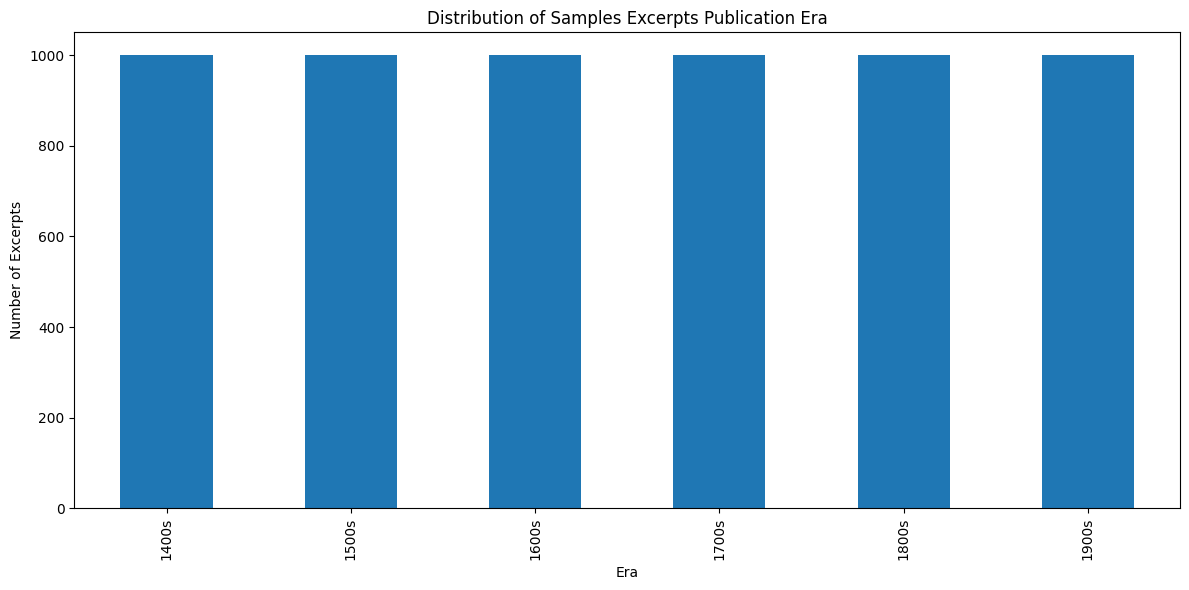

In [14]:
plt.figure(figsize=(12, 6))
era_counts = uniform_excerpts_df["label"].value_counts().sort_index()
era_counts.plot(kind='bar')

plt.title('Distribution of Samples Excerpts Publication Era')
plt.xlabel('Era')
plt.ylabel('Number of Excerpts')

plt.tight_layout()
plt.show()

In [15]:
#uniform_excerpts_df.to_csv('uniform_excerpts.csv', index=False)